In [3]:
import altair as alt
from vega_datasets import data

source = alt.UrlData(
    data.flights_2k.url,
    format={'parse': {'date': 'date'}}
)

brush = alt.selection(type='interval', encodings=['x'])

# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart().mark_bar().encode(
    x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
    y='count()'
).properties(
    width=160,
    height=130
)

# gray background with selection
background = base.encode(
    color=alt.value('#ddd')
).add_selection(brush)

# blue highlights on the transformed data
highlight = base.transform_filter(brush)

# layer the two charts & repeat
alt.layer(
    background,
    highlight,
    data=source
).transform_calculate(
    "time",
    "hours(datum.date)"
).repeat(column=["distance", "delay", "time"])

alt.RepeatChart(...)

In [4]:
import altair as alt
from vega_datasets import data

source = data.stocks()

highlight = alt.selection(type='single', on='mouseover',
                          fields=['symbol'], nearest=True)

base = alt.Chart(source).encode(
    x='date:T',
    y='price:Q',
    color='symbol:N'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines

alt.LayerChart(...)

In [6]:
from traffic.core import Traffic

In [7]:
f_dep_path = "../data/intermediate/taxi_zurich_2019_takeoff_TWY_.pkl"
traf = Traffic.from_file(f_dep_path)
traf

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
flight_id,
SWR789_10293,28140
SWR98H_12406,18975
SWR161_14879,18354
SWR189_15168,17244
SWR161_14909,17193
SWR161_15211,17113
SWR189_14920,16668
SWR189_15219,16586
SWR189_15171,16281


In [8]:
traf[4].data.columns

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['alert', 'altitude', 'callsign', 'day', 'destination', 'firstseen',
       'geoaltitude', 'groundspeed', 'hour', 'icao24', 'last_position',
       'lastseen', 'latitude', 'longitude', 'onground', 'origin', 'spi',
       'squawk', 'timestamp', 'track', 'vertical_rate', 'flight_id', 'twy'],
      dtype='object')

In [56]:
twy_names+"_"

array(['E_', 'G_', 'K_', 'H_', 'F_', 'A_', 'L_', 'R_', 'Z_', 'D_', 'B_',
       'C_', 'J_', 'Y_', 'N_', 'M_', 'P_'], dtype=object)

In [58]:
import pandas as pd

In [153]:
twy_names = traf.query("twy==twy").data.twy.unique()
d_twy = {n: pd.DataFrame(columns=["start", "stop"]) for n in twy_names}
# pd.DataFrame(columns=pd.MultiIndex.from_product([twy_names, ['entry', 'exit']], names=['twy', 'time']))

for f in traf[:100]:
    if not f.data.twy.isna().all():
        c = show_twy(f)
        # s=f.query('twy==twy').data.groupby('twy').agg({'timestamp': ['min', 'max']})
        df = f.onground().query("twy==twy").data
        # counting number of occurences for each twy and time spent on each
        twys_times = (
            df.groupby((df.twy != df.twy.shift()).cumsum())
            .agg({"timestamp": ["min", "max"], "twy": "max"})
            .assign(dur=lambda x: x[("timestamp", "max")] - x[("timestamp", "min")])
        )  # .reset_index()
        # if duplicated taxiways, select only the one with the longest duration spent on it
        twys_times = twys_times.sort_values("dur").drop_duplicates(
            subset=("twy", "max"), keep="last"
        )
        for i, r in twys_times.iterrows():
            twy = r[("twy", "max")]
            d_twy[twy] = d_twy[twy].append(
                {"start": r[("timestamp", "min")], "stop": r[("timestamp", "max")]},
                ignore_index=True,
            )

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [155]:
res_df = pd.DataFrame([])
for i,df in d_twy.items():
    new_df = df.melt(var_name="status", value_name="time").sort_values("time")
    new_df["counter"] = new_df["status"].map({"start": 1, "stop": -1}).cumsum()
    res_df[i]=new_df
res_df

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [29]:
 
def show_twy(f):
    return alt.Chart(f.data[['latitude', 'longitude', 'twy', 'timestamp']]).mark_point().encode(latitude='latitude', longitude='longitude', color='twy', tooltip='hoursminutesseconds(timestamp)')

show_twy(f.onground())

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alt.Chart(...)

In [157]:
from pickle import load

with open("../data/intermediate/twy_occ_dictionnary.pkl", "rb") as f:
    d_twy = load(f)
d_twy

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'H':                           start                      stop
 0     2019-10-20 11:11:39+00:00 2019-10-20 11:13:16+00:00
 1     2019-10-13 06:23:45+00:00 2019-10-13 06:24:21+00:00
 2     2019-10-09 17:10:46+00:00 2019-10-09 17:12:10+00:00
 3     2019-10-10 13:33:37+00:00 2019-10-10 13:34:13+00:00
 4     2019-10-10 07:52:29+00:00 2019-10-10 07:53:56+00:00
 ...                         ...                       ...
 17451 2019-11-26 11:51:52+00:00 2019-11-26 11:53:50+00:00
 17452 2019-10-24 08:03:08+00:00 2019-10-24 08:04:37+00:00
 17453 2019-10-02 17:24:35+00:00 2019-10-02 17:26:01+00:00
 17454 2019-10-19 12:16:25+00:00 2019-10-19 12:18:05+00:00
 17455 2019-11-27 07:30:04+00:00 2019-11-27 07:32:19+00:00
 
 [17456 rows x 2 columns],
 'K':                          start                      stop
 0    2019-10-20 11:13:17+00:00 2019-10-20 11:14:05+00:00
 1    2019-10-13 06:22:28+00:00 2019-10-13 06:23:44+00:00
 2    2019-10-09 17:12:11+00:00 2019-10-09 17:12:41+00:00
 3    2019-10-10 13:3

In [172]:
from ground_analysis.utils import within_Xmin
from ground_analysis.extract_flight_info import onehot_runways

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [232]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df2.pkl")

In [233]:
df = d_twy["L"]

for i, df in d_twy.items():
    new_df = df.melt(var_name="status", value_name="time").sort_values("time")
    new_df["counter"] = new_df["status"].map({"start": 1, "stop": -1}).cumsum()
    new_df.loc[new_df.counter < 0, "counter"] = 0

    dep_arr_df = (
        pd.merge_asof(
            dep_arr_df.sort_values("first_movement_start"),
            new_df,
            left_on="first_movement_start",
            right_on="time",
            direction="backward",  # In order to not preshot the entry of a future aircraft on a twy
        )
        .drop(["status", "time"], axis=1)
        .rename(columns={"counter": f"{i}_occ"})
    )
    dep_arr_df[f"{i}_occ"] = dep_arr_df[f"{i}_occ"].fillna(0)

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [222]:
alt.Chart(
    new_df.query(
        '"2019-10-17 00:00:00+00:00"<time<"2019-11-30 00:00:00+00:00" & counter==counter'
    )
).mark_bar().encode(x="time:T", y="counter:Q", tooltip="time")

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


alt.Chart(...)

In [234]:
dep_arr_df.columns

/home/service/miniconda3/envs/py39v7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['flight_id', 'on_runway_time', 'taxi_holding_time', 'rwy_holding_time',
       'total_holding_time', 'taxi_holding_time_minutes', 'first_movement',
       'callsign', 'registration', 'typecode', 'icao24', 'firstseen_min',
       'start', 'stop', 'duration', 'cumdist_max', 'parking_position',
       'parking_position_duration', 'runway', 'pb_duration', 'end_pb',
       'duration_minutes', 'parking_position_duration_minutes',
       'pb_duration_minutes', 'first_movement_start', 'taxi_dist',
       'total_holding_time_minutes', 'real_dur', 'real_dur_minutes', 'airline',
       'hh', 'hh_num', 'angle_sum', 'avg_speed', 'mvt_type', 'taxiing_stop',
       'avg_outbound_delay_lastXmin', 'nominal', 'busy', 'disrupted',
       'not_nom_arrival_ratio', 'press', 'temp', 'atmap_visibility',
       'atmap_wind', 'atmap_precipitation', 'atmap_freezing', 'atmap_danger',
       'config', 'nb_arr', 'nb_dep', 'nb', 'icao_wtc', 'H', 'L', 'L/M', 'M',
       'H_count', 'L_count', 'L/M_count', 'M_co

<AxesSubplot:>

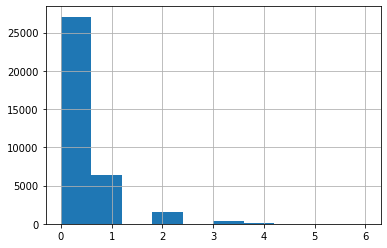

In [235]:
dep_arr_df.E_occ.hist()

In [238]:
from pickle import dump

In [239]:
with open("../data/intermediate/twy_occ_dictionnary.pkl", "wb") as f:
    dump(d_twy, f)